In [306]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from tqdm import tqdm

In [321]:
"Hyper parameters"
batch_size_train = 64
batch_size_val = 1000
n_epochs = 7
learning_rate = 0.0014
momentum = 0.5

In [322]:
"load the data from the folders"
def get_data():
    data_dir = '/Users/xiaodanwu/Desktop/8th/AI/final.project/data' #change here the path 
    # resize to sqaure
    transform1 = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    transform2 = transforms.Compose([transforms.Resize((224,224)),transforms.GaussianBlur(kernel_size=(5, 9)),transforms.RandomRotation(degrees=(0, 30)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

    # ImageFolder automatically assign labels to imgs using the name of their folder
    train_set = []
    for i in range(1,3):
        if i == 1:
            transform = transform1
        else: 
            transform = transform2
        for data in datasets.ImageFolder(data_dir + '/train',transform=transform):
            train_set.append(data)
    
    val_set = datasets.ImageFolder(data_dir + '/val',transform=transform)
    
    img, label = train_set[0]
    print("my input data size: ", img.shape, len(train_set))

    train_loader = DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size_val, shuffle=True)

    return train_loader, val_loader
train_loader, val_loader = get_data()

my input data size:  torch.Size([3, 224, 224]) 1360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


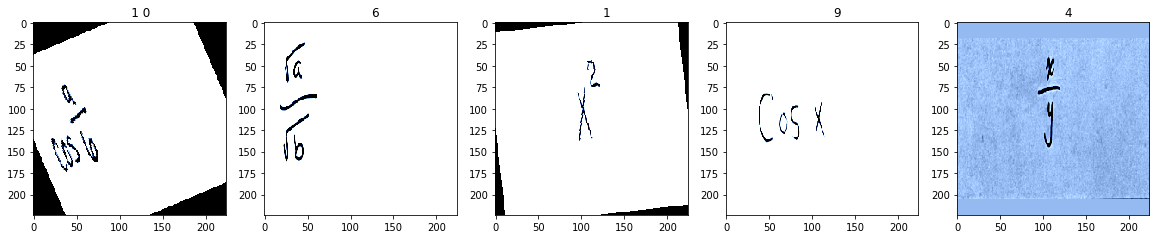

torch.Size([64, 3, 224, 224])


In [323]:
"visualize first 5 images"
def train_imshow(train_loader):
    classes = ('1', '10', '2', '3', '4', '5', '6', '7', '8', '9') # Defining the classes we have
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(20, 8), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1,2,0).squeeze()) 
        ax.title.set_text(' '.join('%5s' % classes[labels[i]]))
    plt.show()
train_imshow(train_loader)
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    break

In [324]:
"define the cnn model"
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(5780, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 5780)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, -1)


In [325]:
def test(model, test_loader, device):
    # evaluation, freeze 
    model.eval()
    total_num = 0
    total_correct = 0
    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            
            data = data.to(device)
            target = target.to(device)
            
            predict_one_hot = model(data)
            
            _, predict_label = torch.max(predict_one_hot, 1)
            # print(predict_label)
            total_correct += (predict_label == target).sum().item()
            total_num += target.size(0)
        
    return (total_correct / total_num)

In [326]:
"define the training procedure"
def train(model, train_loader, test_loader, num_epoch, learning_rate, momentum, device):
    train_losses = []
    # 1, define optimizer
    "TODO: try different optimizer"
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    for epoch in tqdm(range(num_epoch)):
        # train the model
        model.train()
        for i, (data, target) in enumerate(train_loader):
            
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            
            # 2, forward
            output = network(data)
            
            # 3, calculate the loss
            "TODO: try use cross entropy loss instead "
            loss = F.nll_loss(output, target)
            train_losses.append(loss)
            # 4, backward
            loss.backward()
            optimizer.step()
        # evaluate the accuracy on test data for each epoch
        accuracy = test(model, test_loader, device)
        print('accuracy: ', accuracy)
        print("loss: ",loss)
    print("all train losses: ", train_losses)

In [327]:
device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# network = Net().to(device0)
network = models.resnet18(pretrained=True)
train(model=network, train_loader=train_loader, test_loader=val_loader, num_epoch=n_epochs, learning_rate=learning_rate, momentum=momentum, device=device0)

 14%|█▍        | 1/7 [03:14<19:29, 194.95s/it]

accuracy:  0.6388888888888888
loss:  tensor(-43.5610, grad_fn=<NllLossBackward0>)


 29%|██▊       | 2/7 [06:29<16:13, 194.79s/it]

accuracy:  0.8222222222222222
loss:  tensor(-68.2389, grad_fn=<NllLossBackward0>)


 43%|████▎     | 3/7 [09:31<12:44, 191.12s/it]

accuracy:  0.8888888888888888
loss:  tensor(-86.8698, grad_fn=<NllLossBackward0>)


 57%|█████▋    | 4/7 [12:34<09:25, 188.56s/it]

accuracy:  0.8833333333333333
loss:  tensor(-120.8163, grad_fn=<NllLossBackward0>)


 71%|███████▏  | 5/7 [15:37<06:14, 187.04s/it]

accuracy:  0.8
loss:  tensor(-140.7635, grad_fn=<NllLossBackward0>)


 86%|████████▌ | 6/7 [18:40<03:05, 185.67s/it]

accuracy:  0.8777777777777778
loss:  tensor(-199.4243, grad_fn=<NllLossBackward0>)


100%|██████████| 7/7 [21:38<00:00, 185.55s/it]

accuracy:  0.9666666666666667
loss:  tensor(-245.5564, grad_fn=<NllLossBackward0>)
all train losses:  [tensor(0.2067, grad_fn=<NllLossBackward0>), tensor(-2.3038, grad_fn=<NllLossBackward0>), tensor(-7.7409, grad_fn=<NllLossBackward0>), tensor(-11.8940, grad_fn=<NllLossBackward0>), tensor(-16.6852, grad_fn=<NllLossBackward0>), tensor(-19.4182, grad_fn=<NllLossBackward0>), tensor(-20.8683, grad_fn=<NllLossBackward0>), tensor(-23.0378, grad_fn=<NllLossBackward0>), tensor(-27.4140, grad_fn=<NllLossBackward0>), tensor(-29.1058, grad_fn=<NllLossBackward0>), tensor(-30.1230, grad_fn=<NllLossBackward0>), tensor(-32.8677, grad_fn=<NllLossBackward0>), tensor(-33.3042, grad_fn=<NllLossBackward0>), tensor(-34.7534, grad_fn=<NllLossBackward0>), tensor(-37.4187, grad_fn=<NllLossBackward0>), tensor(-37.4562, grad_fn=<NllLossBackward0>), tensor(-41.0974, grad_fn=<NllLossBackward0>), tensor(-40.7304, grad_fn=<NllLossBackward0>), tensor(-40.9794, grad_fn=<NllLossBackward0>), tensor(-44.6960, grad_fn=<N